In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os
import glob


In [2]:
# Initial parameters
epochs = 100
lr = 1e-3
batch_size = 64
img_dims = (96, 96, 3)

data = []
labels = []


In [3]:

# Load image files from the dataset
dataset_path=r'C:\Users\HRISHIKESH\Downloads\Gender-Detection-master\Gender-Detection-master'
image_files = [f for f in glob.glob(dataset_path + "/**/*", recursive=True) if not os.path.isdir(f)]
random.shuffle(image_files)


In [4]:
# Converting images to arrays and labeling the categories
for img in image_files:
    image = cv2.imread(img)

    if image is None:  # Skip unreadable images
        print(f"Warning: Could not read {img}")
        continue

    image = cv2.resize(image, (img_dims[0], img_dims[1]))
    image = img_to_array(image)
    data.append(image)

    label = img.split(os.path.sep)[-2]
    label = 1 if label.lower() == "woman" else 0  # Ensure case-insensitive comparison
    labels.append([label])


In [5]:
# Pre-processing
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [6]:
# Split dataset for training and validation
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2, random_state=42)
trainY = to_categorical(trainY, num_classes=2)
testY = to_categorical(testY, num_classes=2)

In [7]:
# Augmenting dataset
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")


In [8]:
# Define model
def build(width, height, depth, classes):
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1

    if K.image_data_format() == "channels_first":
        inputShape = (depth, height, width)
        chanDim = 1
    
    model.add(Conv2D(32, (3,3), padding="same", input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    
    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(classes))
    model.add(Activation("sigmoid"))

    return model


In [9]:
# Build model
model = build(width=img_dims[0], height=img_dims[1], depth=img_dims[2], classes=2)

c:\Users\HRISHIKESH\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
# Compile the model
opt = Adam(learning_rate=lr, decay=lr/epochs)  # Use learning_rate instead of lr
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])  # Remove brackets around opt



c:\Users\HRISHIKESH\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [11]:
# Train the model
H = model.fit(aug.flow(trainX, trainY, batch_size=batch_size),
              validation_data=(testX, testY),
              steps_per_epoch=len(trainX) // batch_size,
              epochs=epochs, verbose=1)

c:\Users\HRISHIKESH\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 23s 571ms/step - accuracy: 0.6798 - loss: 0.9298 - val_accuracy: 0.6472 - val_loss: 0.6624
Epoch 2/100
 1/28 ━━━━━━━━━━━━━━━━━━━━ 10s 377ms/step - accuracy: 0.8438 - loss: 0.4301

c:\Users\HRISHIKESH\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8438 - loss: 0.4301 - val_accuracy: 0.6494 - val_loss: 0.6638
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 462ms/step - accuracy: 0.8264 - loss: 0.4598 - val_accuracy: 0.6364 - val_loss: 0.6439
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7188 - loss: 0.6250 - val_accuracy: 0.5866 - val_loss: 0.6607
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 429ms/step - accuracy: 0.8109 - loss: 0.4491 - val_accuracy: 0.5996 - val_loss: 0.6400
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8750 - loss: 0.3335 - val_accuracy: 0.6342 - val_loss: 0.6402
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 405ms/step - accuracy: 0.8398 - loss: 0.4019 - val_accuracy: 0.5043 - val_loss: 0.7682
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8281 - loss: 0.3921 - val_accuracy: 0.5065 - val_loss: 0.7439
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 15s 523ms/step - accuracy: 0.8685 - loss: 0.3159 - val_accuracy: 0.4935

In [12]:
# Save the model to disk
model.save('gender_detection.h5')

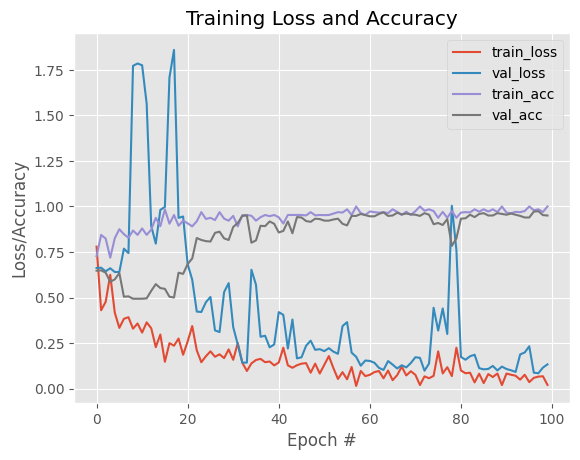

In [13]:
# Plot training/validation loss/accuracy
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")


In [14]:
# Save plot to disk
plt.savefig('plot.png')

<Figure size 640x480 with 0 Axes>